In [1]:
import os
import librosa
import warnings
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from os.path import join as ospj

from bs4.builder import XMLParsedAsHTMLWarning
warnings.filterwarnings('ignore', category=XMLParsedAsHTMLWarning)

# Audio processing

- We will compare ``STFT``, ``Melspectrogram`` and ``Constant-Q Transform`` spectrograms to extract features from our audio files.

In [18]:
SAMPLING_RATE = 44100
BASEPATH = '/local/thiago.poppe/IDMT-SMT-Drums'

In [19]:
if not os.path.exists(BASEPATH):
    print('Run rsync -a /storage/datasets/IDMT-SMT-Drums /local/<your-user>/ to make things work...')

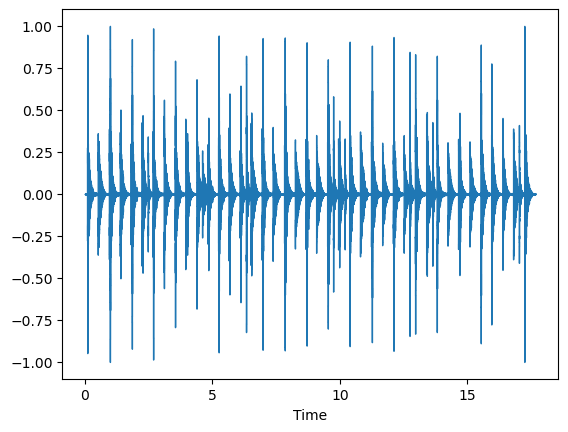

In [20]:
wave, sr = librosa.load(ospj(BASEPATH, 'audio/RealDrum01_00#MIX.wav'), sr=SAMPLING_RATE)
librosa.display.waveshow(y=wave, sr=sr)

In [25]:
def calculate_stft(y):
    spec = np.abs(librosa.stft(y=y))
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    return spec

def calculate_cqt(y, sr):
    spec = np.abs(librosa.cqt(y=y, sr=sr))
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    return spec

def calculate_melspectrogram(y, sr):
    spec = np.abs(librosa.feature.melspectrogram(y=y, sr=sr))
    spec = librosa.amplitude_to_db(spec, ref=np.max)
    
    return spec

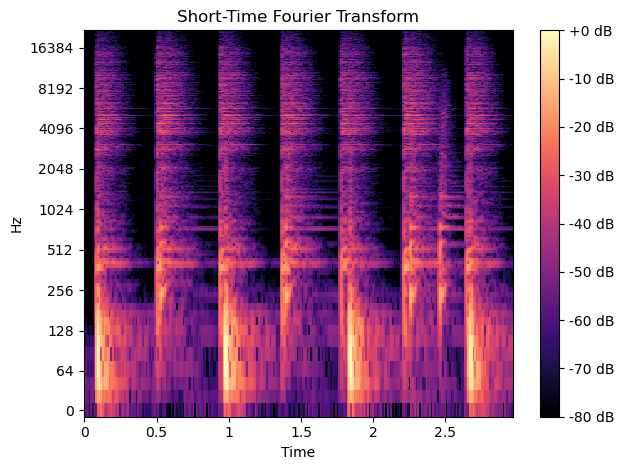

In [26]:
spec = calculate_stft(wave)

fig, ax = plt.subplots()
img = librosa.display.specshow(spec[:, :256], sr=sr, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Short-Time Fourier Transform')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.tight_layout()

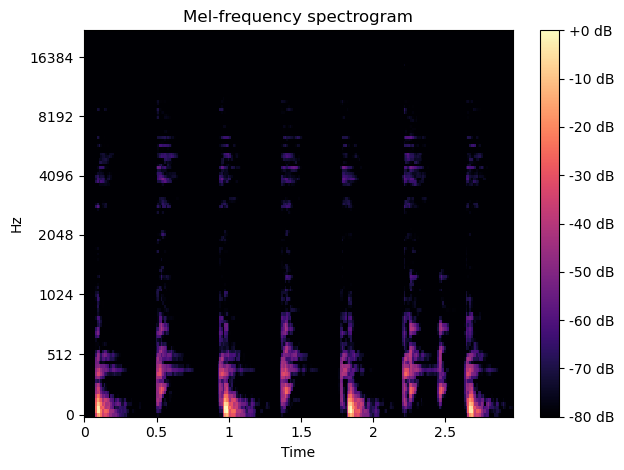

In [27]:
spec = calculate_melspectrogram(wave, sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(spec[:, :256], sr=sr, x_axis='time', y_axis='mel', ax=ax)
ax.set_title('Mel-frequency spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.tight_layout()

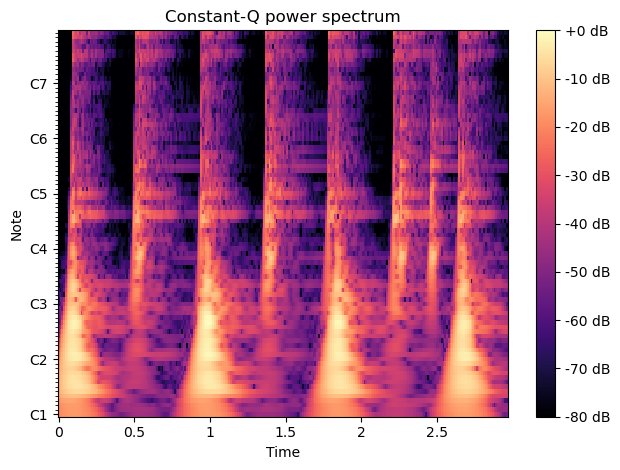

In [28]:
spec = calculate_spectrogram(wave, sr)

fig, ax = plt.subplots()
img = librosa.display.specshow(spec[:, :256], sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.tight_layout()

- We can notice that, among all methods, ``melspectrogram`` seems to isolate better each drum part frequency.

# Label processing

- We will parse each ``.xml`` and create a binary matrix indicating the time where a certain drum part happens in the recording.

In [7]:
with open(ospj(BASEPATH, 'annotation/RealDrum01_00#MIX.xml')) as fp: 
    soup = BeautifulSoup(fp, 'lxml')

events = soup.find_all('event')    
events[0]

<event>
<pitch>0</pitch>
<onsetsec>0.08585</onsetsec>
<offsetsec>0.08585</offsetsec>
<instrument>HH</instrument>
</event>

In [8]:
def create_annotation_matrix(events, sr, num_frames):
    annotations = np.zeros((3, num_frames), dtype=np.float32)
    instrument2index = {'HH': 0, 'SD': 1, 'KD': 2}
    
    for event in events:
        onset = float(event.onsetsec.string)
        instrument = event.instrument.string
        
        index = instrument2index[instrument]
        onset = librosa.time_to_frames(onset, sr=sr)
        annotations[index, onset] = 1.0
    
    return annotations

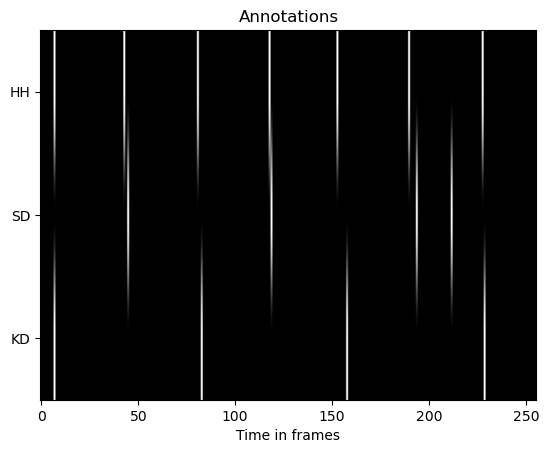

In [9]:
annotations = create_annotation_matrix(events, sr, spec.shape[1])

plt.title('Annotations')
plt.imshow(annotations[:, :256], cmap='gray', aspect='auto')
plt.yticks([0, 1, 2], ['HH', 'SD', 'KD'])
plt.xlabel('Time in frames')
plt.show()

# Joining everything in a single function

In [29]:
def create_feature_and_annotation(songname, sr):
    audiofile = ospj(BASEPATH, f'audio/{songname}.wav')
    annotationfile = ospj(BASEPATH, f'annotation/{songname}.xml')
    
    with open(annotationfile, 'r') as fp:
        soup = BeautifulSoup(fp, 'lxml')
        events = soup.find_all('event')
    
    wave, sr = librosa.load(audiofile, sr=sr)
    spec = calculate_melspectrogram(wave, sr)
    annotation = create_annotation_matrix(events, sr, spec.shape[1])
    
    return spec, annotation

In [30]:
songname = 'RealDrum01_00#MIX'
spec, annotation = create_feature_and_annotation(songname, sr=44100)

print(spec.shape, annotation.shape)

(128, 1524) (3, 1524)


In [31]:
songname = 'RealDrum01_12#MIX'
spec, annotation = create_feature_and_annotation(songname, sr=44100)

print(spec.shape, annotation.shape)

(128, 1807) (3, 1807)


In [38]:
songname = 'WaveDrum01_00#MIX'
spec, annotation = create_feature_and_annotation(songname, sr=44100)

print(spec.shape, annotation.shape)

(128, 1842) (3, 1842)


In [40]:
ipd.display(ipd.Audio(ospj(BASEPATH, f'audio/{songname}.wav'), rate=44100, ))

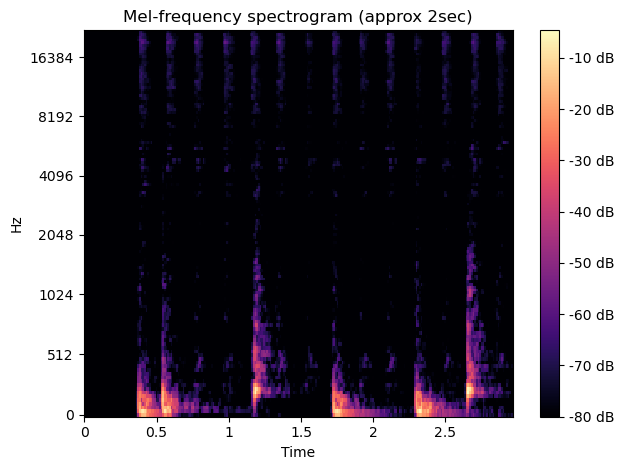

In [41]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spec[:, :256], sr=sr, x_axis='time', y_axis='mel', ax=ax)
ax.set_title('Mel-frequency spectrogram (approx 2sec)')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
fig.tight_layout()

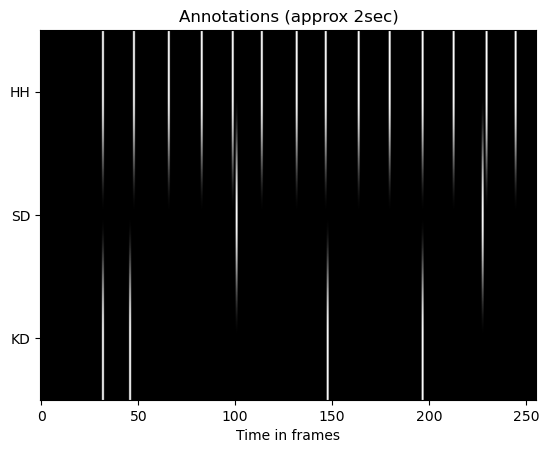

In [42]:
plt.title('Annotations (approx 2sec)')
plt.imshow(annotation[:, :256], cmap='gray', aspect='auto')
plt.yticks([0, 1, 2], ['HH', 'SD', 'KD'])
plt.xlabel('Time in frames')
plt.show()